**Install Framework**

In [ ]:
!pip install scaleogram
!pip install obspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.4 MB 13.3 MB/s 


**Import Library**

In [1]:
import string
import argparse as ap
import sys
import os
import numpy as np

import scaleogram as scg 

import obspy
import obspy.core as oc
from obspy import read_inventory

# from datetime import datetime, timedelta
import time

import pylab as plt
import pandas as pd
import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import datetime
import warnings
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

**Load Dataset**

In [2]:
from google.colab import drive
drive.mount("/content/drive")
#Dataset = '/content/drive/My Drive/11_Dataset_Repository/ECGData/ECGData.mat'
events_metaname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/metadata_Instance_events_10k.csv'
noise_metaname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/metadata_Instance_noise_1k.csv'

events_hdfname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/HDF5/Instance_events_counts_10k.hdf5'
gm_hdfname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/HDF5/Instance_events_gm_10k.hdf5'
noise_hdfname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/HDF5/Instance_noise_1k.hdf5'

eventname = '/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/metadata_Instance_events_10k.csv'
noisename='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/metadata_Instance_noise_1k.csv'

%time df_metadata = pd.read_csv(eventname, dtype={'station_location_code': object})

function_plot='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/Def_plot_waveform.py'

plot_seis='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/plot_siesmogram_component.py'

Mounted at /content/drive
CPU times: user 170 ms, sys: 28.7 ms, total: 198 ms
Wall time: 2.95 s


**Read Dataset**

In [3]:
#Metadata Event CSV
events_metaData = pd.read_csv(events_metaname, keep_default_na=False, dtype={'station_location_code': object, 
           'source_mt_eval_mode':object,'source_mt_status': object,'source_mechanism_strike_dip_rake': object, 
           'source_mechanism_moment_tensor': object, 'trace_p_arrival_time': object, 'trace_s_arrival_time': object},
                             low_memory=False);

#Metadata Event
noise_metaData = pd.read_csv(noise_metaname,dtype={'station_location_code': object}, low_memory=False)

#Metadata Event HDF5
events_h5File = h5py.File(events_hdfname, 'r') # Events in counts
gm_h5File = h5py.File(gm_hdfname, 'r')         # Events in ground motion units
noise_h5File = h5py.File(noise_hdfname, 'r')   # Noise in counts

**Add External Function**

In [4]:
import os
os.chdir("/content/drive/My Drive/11_Dataset_Repository/INSTANCE/")
os.chdir("/content/drive/My Drive/11_Dataset_Repository/Function/")

In [5]:
import Def_plot_waveform
from Def_plot_waveform import split, build_stream, multiple_streams 

import plot_siesmogram_component
from plot_siesmogram_component import componentE

# Some usefull functions
#from Plot_Functions import split, detect_time, bin_width, my_ceil, my_floor, round_up

# Load of the plot functions
#from Plot_Functions import plot_subplot, hist_subplot
#from Plot_Functions import plot_hexbin_panels, plot_histogram, plot_histo_panels, plot_pie_panels

**Table Print Dataset**

In [6]:
events_metaData.head()

,source_id,station_network_code,station_code,station_location_code,station_channels,station_latitude_deg,station_longitude_deg,station_elevation_m,station_vs_30_mps,station_vs_30_detail,...,trace_sa10_cmps2,trace_sa30_cmps2,trace_name,trace_GPD_P_number,trace_GPD_S_number,trace_EQT_number_detections,trace_EQT_P_number,trace_EQT_S_number,trace_deconvolved_units,source_type
0,11030611,IV,OFFI,,HH,42.93500,13.68570,320.0,580.000000,Vs30 extracted from ShakeMap,...,0.001040,9.36700287089e-05,11030611.IV.OFFI..HH,1,2,1.0,1.0,1.0,mps,earthquake
1,11030611,IV,PIEI,,HH,43.53567,12.53500,665.0,778.339556,Vs30 extracted from ShakeMap,...,0.000053,1.49377156134e-05,11030611.IV.PIEI..HH,0,2,1.0,1.0,1.0,mps,earthquake
2,11030611,IV,PIEI,,HN,43.53567,12.53500,665.0,778.339556,Vs30 extracted from ShakeMap,...,0.000239,7.77367705587e-05,11030611.IV.PIEI..HN,2,1,,,,mps2,earthquake
3,11030611,IV,RM33,,EH,42.50898,13.21452,1097.0,721.279254,Vs30 extracted from ShakeMap,...,0.000244,5.49019656038e-05,11030611.IV.RM33..EH,3,7,2.0,2.0,2.0,mps,earthquake
4,11030611,IV,RM33,,HN,42.50898,13.21452,1097.0,721.279254,Vs30 extracted from ShakeMap,...,0.000301,7.51181160727e-05,11030611.IV.RM33..HN,1,3,,,,mps2,earthquake


In [7]:
chosen_lines = []
plots_line = 1
fignumbers = 'abcdefghijklmnopqrstuvwxyz'
alllabs = split(fignumbers)

**Informasi Kejadian Gempa**

In [8]:
cha = 'HH'
TOTAL = events_metaData.loc[events_metaData.station_channels == cha].shape[0]

print ("Jumlah Kejadian Gempa: ", TOTAL)

df_lbk2 = events_metaData.loc[(events_metaData.source_magnitude < 2) &
                             (events_metaData.station_channels == cha)]
#
lbk2 = df_lbk2.shape[0]
print ("Jumlah Kejadian Gempa (Magnitude < 2) : ", lbk2, "Dengan Persentase : ", round(float(lbk2/TOTAL * 100.),2),"%")
#

df_mag2to3 = events_metaData.loc[(events_metaData.source_magnitude >= 2) &
                             (events_metaData.source_magnitude < 3) & 
                             (events_metaData.station_channels == cha)]

#
mag2to3 = df_mag2to3.shape[0]
print ("Jumlah Kejadian Gempa (2 <= Magnitude < 3) : ", mag2to3, "Dengan Persentase : ", round(float(mag2to3/TOTAL * 100.),2),"%")
#

df_mag3to4 = events_metaData.loc[(events_metaData.source_magnitude >= 3) &
                             (events_metaData.source_magnitude < 4) & 
                             (events_metaData.station_channels == cha)]
#
mag3to4 = df_mag3to4.shape[0]
print ("Jumlah Kejadian Gempa (3 <= Magnitude < 4) : ", mag3to4, "Dengan Persentase : ", round(float(mag3to4/TOTAL * 100.),2),"%")

df_magupto4 = events_metaData.loc[(events_metaData.source_magnitude >= 4) &
                             (events_metaData.station_channels == cha)]
#
magupto4 = df_magupto4.shape[0]
print ("Jumlah Kejadian Gempa (Magnitude >= 4): ", magupto4, "Dengan Persentase : ", round(float(magupto4/TOTAL * 100.),2),"%")
#

if mag2to3 > 0:
    lista = list(df_mag2to3.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
elif mag3to4 > 0:
    lista = list(df_mag3to4.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
elif magupto4 > 0:
    lista = list(df_magupto4.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
else:
    print('no waveform found')

Jumlah Kejadian Gempa:  3893
Jumlah Kejadian Gempa (Magnitude < 2) :  749 Dengan Persentase :  19.24 %
Jumlah Kejadian Gempa (2 <= Magnitude < 3) :  2291 Dengan Persentase :  58.85 %
Jumlah Kejadian Gempa (3 <= Magnitude < 4) :  783 Dengan Persentase :  20.11 %
Jumlah Kejadian Gempa (Magnitude >= 4):  70 Dengan Persentase :  1.8 %


**Plot Waveform in 3 Components**

In [9]:
chosen_lines = []
plots_line = 1

df_lbk2 = events_metaData.loc[(events_metaData.source_magnitude < 2)]

if lbk2 > 0:
    lista = list(df_lbk2.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
else:
    print('')

lines = chosen_lines
# Kind of unit
units = len(lines)*["counts"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=int(len(lines)/plots_line)
ncol=plots_line

labs = alllabs[:(ncol*nrow)]

wftype='ev_c'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File

**Component E**

In [10]:
def componentE(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max):

    """
    Build the multi-panel figure for events in counts
    lines : list of lines, lines number of the hdf5 File to plot
    wftype : str, waveform type 'ev_c', 'ev_gm' or 'noise' for events in counts, events in ground motion units or noise, respectively
    nrow : number of rows in figure
    ncol : numebr of columns in figure
    units : list of units
    labs : list of labels for publication
    filt : logical, if you want to apply a bandpass filter to the data
    freq_min and freq_max : minimum and maximum frequency

    """
    title_size = 10
    labelsize = 10
    legendsize = 14
    label_sec=range(0,60,30)
    formatter = mdates.DateFormatter("%H:%M:%S")

    (fig_width, fig_height) = plt.rcParams['figure.figsize']

    fig_size = [fig_width*2*ncol, fig_height*2*nrow]

    fig = plt.figure(figsize=fig_size)
    outer = gridspec.GridSpec(nrow, ncol, wspace=0.4, hspace=0.4)

    irow=3
    for i in range(nrow*ncol):
        inner = gridspec.GridSpecFromSubplotSpec(irow, 1,
                        subplot_spec=outer[i], wspace=0.2, hspace=0.3)

        l=lines[i]
        unit=units[i]
        lab=labs[i]
        st,row = build_stream(df,h5,l, wftype, filt, freq_min, freq_max)
        ev_id = row['source_id']
        if wftype != 'noise':
            timeP = row['trace_P_arrival_time']
            timeS = row['trace_S_arrival_time']
        else:
            timeN = row['trace_start_time']

        smax = st.max()
        absmax = max(abs(n) for n in smax)
        yslim = absmax*1.01

        if wftype != 'noise':
            P_date_time_str = timeP
            P_date_time_obj = datetime.datetime.strptime(P_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

            S_date_time_str = timeS
            if timeS != "" :
                S_date_time_obj = datetime.datetime.strptime(S_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        else:
            N_date_time_str = timeN
            N_date_time_obj = datetime.datetime.strptime(N_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

        custom_lines1 = [Line2D([0], [0], color='k', lw=2),Line2D([0], [0], color='indigo', lw=2),Line2D([0], [0], color='darkorange', lw=2)]
        if wftype != 'noise':
            custom_lines2 = [Line2D([0], [0], color='indigo', lw=2),Line2D([0], [0], color='darkorange', lw=2)]
        net = st[0].stats.network
        sta = st[0].stats.station
        if wftype != 'noise':
                name = str(ev_id) + '.' + net + '.' + sta +'.'+str(P_date_time_obj.date())
        else:
                name = str(ev_id)


        for j in range(1):
            #fig, ax1, ax2 = plt.subplots(2, 1, figsize=(9, 3.5));  
            fig = plt.figure(figsize=(10,5))
            #f = plt.figure(figsize=(10,3))
            ax = fig.add_subplot(2,1,1)
            #ax.fig_size(16,16)
            #plt.Subplot(fig, 111)
            ax.xaxis.set_major_formatter(formatter)
            ax.xaxis.set_major_locator(mdates.SecondLocator(bysecond=label_sec))
            ax.set_ylim(-yslim,yslim)
            ax.plot(st[j].times("matplotlib"), st[j].data, c='k', lw=1, label = "Trace")
            ax.yaxis.set_tick_params(labelleft=True, labelsize=labelsize)
            if wftype != 'noise':
                ax.axvline(date2num(P_date_time_obj), c='indigo', lw=2, label = "Pick_P")
                if timeS != "" :
                    ax.axvline(date2num(S_date_time_obj), c='darkorange', lw=2, label = "Pick_S")
            ax.xaxis.set_tick_params(labelleft=True, labelsize=labelsize)
            ax.set_ylabel(unit,fontsize=labelsize)
            t = ax.yaxis.get_offset_text()
            t.set_size(22)
            if j ==0:
                ch = st[0].stats.channel
                ax.tick_params(labelleft=True, labelbottom=False)
                ax.set_title(name,pad=5,fontsize=title_size)
                ax.text(1, 1.3, lab, transform=ax.transAxes, fontsize=labelsize,ha='right',va='top')
                ax.legend(custom_lines1,[ch],fontsize=legendsize,bbox_to_anchor=(0.99, 0.96), loc=1, borderaxespad=0.,shadow=True)
                ax.set_xlim(date2num(st[0].stats.starttime.datetime),date2num(st[0].stats.endtime.datetime))
                # scg.cws(st[0].times, st[0].data, scales=scales, figsize=(10.0, 4.0), coi = False, ylabel='Scale', xlabel='Time',
                plt.show()
                # title='Scalogram Z Component: scalogram with linear period');
                dt=0.01
                scalogram = cwt(st[0].data, dt, 8, f_min, f_max, wl='morlet')
                #ax2 = plt.Subplot(fig, inner[j])
                #ax2 = fig.add_subplot(111)
                signal_length = 12000
                time = np.arange(signal_length)
                x, y = np.meshgrid(time,np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))
                #fig = plt.figure()
                fig = plt.figure(figsize=(10.15,6))
                ax2 = fig.add_subplot(2, 1, 2)
                ax2.pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)
                ax2.set_xlabel("Time [s]")
                ax2.set_ylabel("Frequency [Hz]")
                ax2.set_yscale('log')
                ax2.set_ylim(f_min, f_max)
                plt.show()
    fig.show()

<Figure size 864x576 with 0 Axes>

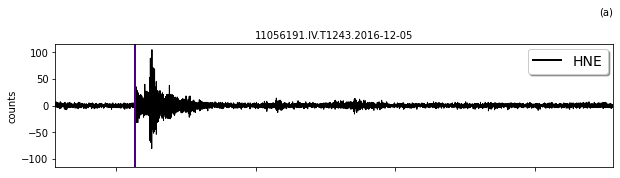

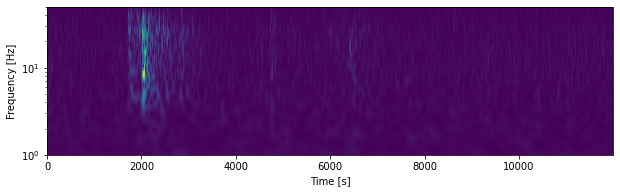

In [11]:
f_min = 1
f_max = 50
componentE(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)

**Component N**

In [13]:
def componentN(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max):

    """
    Build the multi-panel figure for events in counts
    lines : list of lines, lines number of the hdf5 File to plot
    wftype : str, waveform type 'ev_c', 'ev_gm' or 'noise' for events in counts, events in ground motion units or noise, respectively
    nrow : number of rows in figure
    ncol : numebr of columns in figure
    units : list of units
    labs : list of labels for publication
    filt : logical, if you want to apply a bandpass filter to the data
    freq_min and freq_max : minimum and maximum frequency

    """
    title_size = 10
    labelsize = 10
    legendsize = 14
    label_sec=range(0,60,30)
    formatter = mdates.DateFormatter("%H:%M:%S")

    (fig_width, fig_height) = plt.rcParams['figure.figsize']

    fig_size = [fig_width*2*ncol, fig_height*2*nrow]

    fig = plt.figure(figsize=fig_size)
    outer = gridspec.GridSpec(nrow, ncol, wspace=0.4, hspace=0.4)

    irow=3
    for i in range(nrow*ncol):
        inner = gridspec.GridSpecFromSubplotSpec(irow, 1,
                        subplot_spec=outer[i], wspace=0.2, hspace=0.3)

        l=lines[i]
        unit=units[i]
        lab=labs[i]
        st,row = build_stream(df,h5,l, wftype, filt, freq_min, freq_max)
        ev_id = row['source_id']
        if wftype != 'noise':
            timeP = row['trace_P_arrival_time']
            timeS = row['trace_S_arrival_time']
        else:
            timeN = row['trace_start_time']

        smax = st.max()
        absmax = max(abs(n) for n in smax)
        yslim = absmax*1.01

        if wftype != 'noise':
            P_date_time_str = timeP
            P_date_time_obj = datetime.datetime.strptime(P_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

            S_date_time_str = timeS
            if timeS != "" :
                S_date_time_obj = datetime.datetime.strptime(S_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        else:
            N_date_time_str = timeN
            N_date_time_obj = datetime.datetime.strptime(N_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

        custom_lines1 = [Line2D([0], [0], color='k', lw=2),Line2D([0], [0], color='indigo', lw=2),Line2D([0], [0], color='darkorange', lw=2)]
        if wftype != 'noise':
            custom_lines2 = [Line2D([0], [0], color='indigo', lw=2),Line2D([0], [0], color='darkorange', lw=2)]
        net = st[0].stats.network
        sta = st[0].stats.station
        if wftype != 'noise':
                name = str(ev_id) + '.' + net + '.' + sta +'.'+str(P_date_time_obj.date())
        else:
                name = str(ev_id)


        for j in range(1):
            #fig, ax1, ax2 = plt.subplots(2, 1, figsize=(9, 3.5));  
            fig = plt.figure(figsize=(10,5))
            #f = plt.figure(figsize=(10,3))
            ax = fig.add_subplot(2,1,1)
            #ax.fig_size(16,16)
            #plt.Subplot(fig, 111)
            ax.xaxis.set_major_formatter(formatter)
            ax.xaxis.set_major_locator(mdates.SecondLocator(bysecond=label_sec))
            ax.set_ylim(-yslim,yslim)
            ax.plot(st[j].times("matplotlib"), st[j].data, c='k', lw=1, label = "Trace")
            ax.yaxis.set_tick_params(labelleft=True, labelsize=labelsize)
            if wftype != 'noise':
                ax.axvline(date2num(P_date_time_obj), c='indigo', lw=2, label = "Pick_P")
                if timeS != "" :
                    ax.axvline(date2num(S_date_time_obj), c='darkorange', lw=2, label = "Pick_S")
            ax.xaxis.set_tick_params(labelleft=True, labelsize=labelsize)
            ax.set_ylabel(unit,fontsize=labelsize)
            t = ax.yaxis.get_offset_text()
            t.set_size(22)
            if j ==0:
                ch = st[1].stats.channel
                ax.tick_params(labelleft=True, labelbottom=False)
                ax.set_title(name,pad=5,fontsize=title_size)
                ax.text(1, 1.3, lab, transform=ax.transAxes, fontsize=labelsize,ha='right',va='top')
                ax.legend(custom_lines1,[ch],fontsize=legendsize,bbox_to_anchor=(0.99, 0.96), loc=1, borderaxespad=0.,shadow=True)
                ax.set_xlim(date2num(st[1].stats.starttime.datetime),date2num(st[1].stats.endtime.datetime))
                # scg.cws(st[0].times, st[0].data, scales=scales, figsize=(10.0, 4.0), coi = False, ylabel='Scale', xlabel='Time',
                plt.show()
                # title='Scalogram Z Component: scalogram with linear period');
                dt=0.01
                scalogram = cwt(st[1].data, dt, 8, f_min, f_max, wl='morlet')
                #ax2 = plt.Subplot(fig, inner[j])
                #ax2 = fig.add_subplot(111)
                signal_length = 12000
                time = np.arange(signal_length)
                x, y = np.meshgrid(time,np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))
                #fig = plt.figure()
                fig = plt.figure(figsize=(10.15,6))
                ax2 = fig.add_subplot(2, 1, 2)
                ax2.pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)
                ax2.set_xlabel("Time [s]")
                ax2.set_ylabel("Frequency [Hz]")
                ax2.set_yscale('log')
                ax2.set_ylim(f_min, f_max)
                plt.show()
    fig.show()

<Figure size 864x576 with 0 Axes>

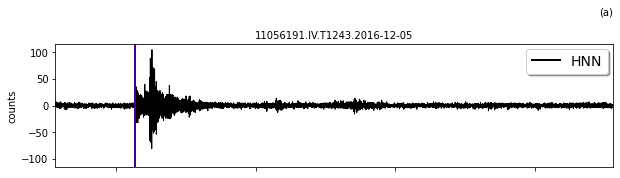

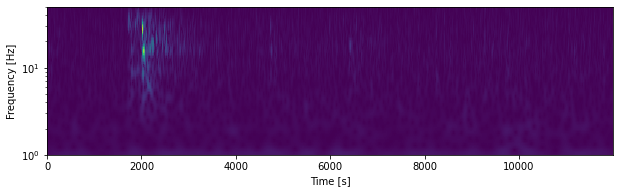

In [14]:
f_min = 1
f_max = 50
componentN(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)

**Component Z**

In [15]:
def componentZ(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max):

    """
    Build the multi-panel figure for events in counts
    lines : list of lines, lines number of the hdf5 File to plot
    wftype : str, waveform type 'ev_c', 'ev_gm' or 'noise' for events in counts, events in ground motion units or noise, respectively
    nrow : number of rows in figure
    ncol : numebr of columns in figure
    units : list of units
    labs : list of labels for publication
    filt : logical, if you want to apply a bandpass filter to the data
    freq_min and freq_max : minimum and maximum frequency

    """
    title_size = 10
    labelsize = 10
    legendsize = 14
    label_sec=range(0,60,30)
    formatter = mdates.DateFormatter("%H:%M:%S")

    (fig_width, fig_height) = plt.rcParams['figure.figsize']

    fig_size = [fig_width*2*ncol, fig_height*2*nrow]

    fig = plt.figure(figsize=fig_size)
    outer = gridspec.GridSpec(nrow, ncol, wspace=0.4, hspace=0.4)

    irow=3
    for i in range(nrow*ncol):
        inner = gridspec.GridSpecFromSubplotSpec(irow, 1,
                        subplot_spec=outer[i], wspace=0.2, hspace=0.3)

        l=lines[i]
        unit=units[i]
        lab=labs[i]
        st,row = build_stream(df,h5,l, wftype, filt, freq_min, freq_max)
        ev_id = row['source_id']
        if wftype != 'noise':
            timeP = row['trace_P_arrival_time']
            timeS = row['trace_S_arrival_time']
        else:
            timeN = row['trace_start_time']

        smax = st.max()
        absmax = max(abs(n) for n in smax)
        yslim = absmax*1.01

        if wftype != 'noise':
            P_date_time_str = timeP
            P_date_time_obj = datetime.datetime.strptime(P_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

            S_date_time_str = timeS
            if timeS != "" :
                S_date_time_obj = datetime.datetime.strptime(S_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        else:
            N_date_time_str = timeN
            N_date_time_obj = datetime.datetime.strptime(N_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

        custom_lines1 = [Line2D([0], [0], color='k', lw=2),Line2D([0], [0], color='indigo', lw=2),Line2D([0], [0], color='darkorange', lw=2)]
        if wftype != 'noise':
            custom_lines2 = [Line2D([0], [0], color='indigo', lw=2),Line2D([0], [0], color='darkorange', lw=2)]
        net = st[2].stats.network
        sta = st[2].stats.station
        if wftype != 'noise':
                name = str(ev_id) + '.' + net + '.' + sta +'.'+str(P_date_time_obj.date())
        else:
                name = str(ev_id)

        for j in range(1):
            #fig, ax1, ax2 = plt.subplots(2, 1, figsize=(9, 3.5));  
            fig = plt.figure(figsize=(10,5))
            #f = plt.figure(figsize=(10,3))
            ax = fig.add_subplot(2,1,1)
            #ax.fig_size(16,16)
            #plt.Subplot(fig, 111)
            ax.xaxis.set_major_formatter(formatter)
            ax.xaxis.set_major_locator(mdates.SecondLocator(bysecond=label_sec))
            ax.set_ylim(-yslim,yslim)
            ax.plot(st[j].times("matplotlib"), st[j].data, c='k', lw=1, label = "Trace")
            ax.yaxis.set_tick_params(labelleft=True, labelsize=labelsize)
            if wftype != 'noise':
                ax.axvline(date2num(P_date_time_obj), c='indigo', lw=2, label = "Pick_P")
                if timeS != "" :
                    ax.axvline(date2num(S_date_time_obj), c='darkorange', lw=2, label = "Pick_S")
            ax.xaxis.set_tick_params(labelleft=True, labelsize=labelsize)
            ax.set_ylabel(unit,fontsize=labelsize)
            t = ax.yaxis.get_offset_text()
            t.set_size(22)
            if j ==0:
                ch = st[2].stats.channel
                ax.tick_params(labelleft=True, labelbottom=False)
                ax.set_title(name,pad=5,fontsize=title_size)
                ax.text(1, 1.3, lab, transform=ax.transAxes, fontsize=labelsize,ha='right',va='top')
                ax.legend(custom_lines1,[ch],fontsize=legendsize,bbox_to_anchor=(0.99, 0.96), loc=1, borderaxespad=0.,shadow=True)
                ax.set_xlim(date2num(st[2].stats.starttime.datetime),date2num(st[2].stats.endtime.datetime))
                # scg.cws(st[0].times, st[0].data, scales=scales, figsize=(10.0, 4.0), coi = False, ylabel='Scale', xlabel='Time',
                plt.show()
                # title='Scalogram Z Component: scalogram with linear period');
                dt=0.01
                scalogram = cwt(st[2].data, dt, 8, f_min, f_max, wl='morlet')
                #ax2 = plt.Subplot(fig, inner[j])
                #ax2 = fig.add_subplot(111)
                signal_length = 12000
                time = np.arange(signal_length)
                x, y = np.meshgrid(time,np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))
                #fig = plt.figure()
                fig = plt.figure(figsize=(10.15,6))
                ax2 = fig.add_subplot(2, 1, 2)
                ax2.pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)
                ax2.set_xlabel("Time [s]")
                ax2.set_ylabel("Frequency [Hz]")
                ax2.set_yscale('log')
                ax2.set_ylim(f_min, f_max)
                plt.show()
    fig.show()

<Figure size 864x576 with 0 Axes>

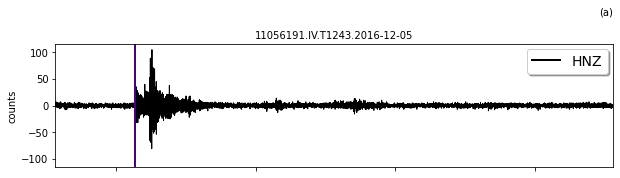

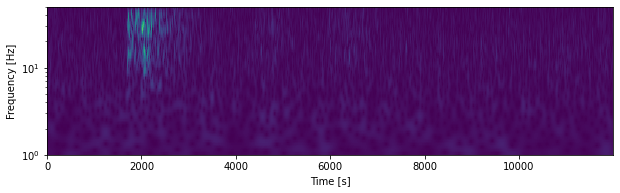

In [16]:
f_min = 1
f_max = 50
componentZ(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)